# AI Travel Agent & Expense Planner

This Jupyter Notebook implements a network multi-agent system for travel planning using LangGraph. The system features:
- **Network Communication**: Agents communicate via a `Command` type with `update` and `goto` fields for precise control.
- **Dynamic Tool Invocation**: Each agent uses `llm_with_tools` to process prompts and invoke tools dynamically based on LLM responses.
- **Agents**: Weather, Attractions, Hotels, Itinerary, Expenses, Currency, Summary, and Message Broker.
- **Workflow**: Weather → Attractions → Hotels → Itinerary → Expenses → Currency → Summary.
- **Features**: Pydantic models for structured data, specific prompts for each agent, `MemorySaver` for persistence, robust error handling.
- **Command Support**: `command(update={}, goto="goto")`, `plan_trip`, `retrieve_plan`.

The agents now leverage `llm_with_tools.invoke()` to process prompts and select tools, with fallbacks to direct tool calls for robustness. Below are the implementation details and example usage.

In [1]:
print('OK')

OK


In [2]:
# Imports
import datetime
from typing import Dict, List, TypedDict, Optional, Any
from pydantic import BaseModel, ValidationError
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
import requests
import uuid
from langchain_core.messages import AIMessage

In [3]:
# LOAD ENVIRONMENT VARIABLES
# Make sure to have a .env file with the required keys
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["WEATHER_API_KEY"]=os.getenv("WEATHER_API_KEY")
## Langsmith Tracking And Tracing
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]="true"

In [4]:
# Pydantic Models
class Weather(BaseModel):
    date: str
    temperature: float
    condition: str

class Attraction(BaseModel):
    name: str
    description: str
    cost: float

class Restaurant(BaseModel):
    name: str
    cuisine: str
    avg_cost_per_person: float

class Activity(BaseModel):
    name: str
    description: str
    cost: float

class Transportation(BaseModel):
    mode: str
    cost_per_day: float

class Hotel(BaseModel):
    name: str
    daily_rate: float
    rating: float

class DayPlan(BaseModel):
    date: str
    attractions: List[Attraction]
    activities: List[Activity]
    meals: List[Restaurant]
    transportation: Transportation

class TripSummary(BaseModel):
    city: str
    start_date: str
    days: int
    summary: str

# Command Model
class Command(BaseModel):
    command_type: str
    update: Optional[Dict] = None
    goto: Optional[str] = None
    payload: Optional[Dict] = None
    sender: str
    recipient: str

# Graph State
class TravelState(TypedDict):
    city: str
    start_date: str
    days: int
    budget_range: tuple
    user_currency: str
    current_weather: Weather
    weather_forecast: List[Weather]
    attractions: List[Attraction]
    restaurants: List[Restaurant]
    activities: List[Activity]
    transportation: Transportation
    hotel: Hotel
    hotel_cost: float
    itinerary: List[DayPlan]
    daily_costs: List[float]
    total_cost_local: float
    daily_budget_local: float
    total_cost_user: float
    daily_budget_user: float
    summary: TripSummary
    session_id: str
    history: List[Dict]
    commands: List[Command]
    current_command: Optional[Command]
    response: Optional[Dict]

In [5]:
# Prompts
WEATHER_PROMPT = PromptTemplate(
    input_variables=["city", "days", "update", "command_type"],
    template="""
You are a Weather Agent in a travel planning system. Your role is to fetch current weather and forecast data.
Received command:
- Command type: {command_type}
- City: {city}
- Days: {days}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (get_current_weather, get_weather_forecast) to fetch weather data for the city and duration.
3. Return a structured response with weather data in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

ATTRACTIONS_PROMPT = PromptTemplate(
    input_variables=["city", "update", "command_type"],
    template="""
You are an Attractions Agent in a travel planning system. Your role is to find attractions, restaurants, activities, and transportation options.
Received command:
- Command type: {command_type}
- City: {city}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (search_attractions, search_restaurants, search_activities, search_transportation) to find relevant options in the city.
3. Return a structured response with the search results in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message broker_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent_agent.
"""
)

HOTELS_PROMPT = PromptTemplate(
    input_variables=["city", "budget_range", "days", "update", "command_type"],
    template="""
You are a Hotels Agent in a travel planning system. Your role is to find hotels and estimate costs.
Received command:
- Command type: {command_type}
- City: {city}
- Budget range: {budget_range}
- Days: {days}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (search_hotels, estimate_hotel_cost) to find a hotel within the budget range and estimate the total cost.
3. Return a structured response with hotel details and cost in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

ITINERARY_PROMPT = PromptTemplate(
    input_variables=["city", "start_date", "days", "attractions", "activities", "restaurants", "transportation", "update", "command_type"],
    template="""
You are an Itinerary Agent in a travel planning system. Your role is to create a travel itinerary.
Received command:
- Command type: {command_type}
- City: {city}
- Start date: {start_date}
- Days: {days}
- Attractions: {attractions}
- Activities: {activities}
- Restaurants: {restaurants}
- Transportation: {transportation}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (create_day_plan, create_full_itinerary) to create a full itinerary with daily plans.
3. Return a structured response with the itinerary in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

EXPENSES_PROMPT = PromptTemplate(
    input_variables=["itinerary", "hotel_cost", "days", "update", "command_type"],
    template="""
You are an Expenses Agent in a travel planning system. Your role is to calculate trip costs.
Received command:
- Command type: {command_type}
- Itinerary: {itinerary}
- Hotel cost: {hotel_cost}
- Days: {days}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (calculate_daily_cost, calculate_total_cost, calculate_daily_budget) to calculate costs.
3. Return a structured response with cost details in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

CURRENCY_PROMPT = PromptTemplate(
    input_variables=["total_cost_local", "daily_budget_local", "user_currency", "update", "command_type"],
    template="""
You are a Currency Agent in a travel planning system. Your role is to convert costs to the user's currency.
Received command:
- Command type: {command_type}
- Total cost (local): {total_cost_local}
- Daily budget (local): {daily_budget_local}
- User currency: {user_currency}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. Use your tools (get_exchange_rate, convert_currency) to convert costs to the user's currency.
3. Return a structured response with converted costs in JSON format.
4. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

SUMMARY_PROMPT = PromptTemplate(
    input_variables=["city", "start_date", "days", "current_weather", "itinerary", "hotel", "total_cost_user", "daily_budget_user", "user_currency", "update", "command_type", "session_id"],
    template="""
You are a Summary Agent in a travel planning system. Your role is to create trip summaries or retrieve past plans.
Received command:
- Command type: {command_type}
- City: {city}
- Start date: {start_date}
- Days: {days}
- Current weather: {current_weather}
- Itinerary: {itinerary}
- Hotel: {hotel}
- Total cost (user currency): {total_cost_user}
- Daily budget (user currency): {daily_budget_user}
- User currency: {user_currency}
- Session ID: {session_id}
- Updates: {update}

Instructions:
1. Apply any state updates provided.
2. If command_type is 'update_goto', use create_trip_summary to generate a summary.
3. If command_type is 'retrieve_plan', use retrieve_previous_plan to fetch the plan.
4. Return a structured response in JSON format.
5. If the command is invalid, return an error message in JSON format.

Execute the task and send the response to the Message Broker.
"""
)

BROKER_PROMPT = PromptTemplate(
    input_variables=["command_type", "payload", "update", "goto", "sender", "recipient"],
    template="""
You are a Message Broker Agent in a travel planning system, responsible for routing commands to the appropriate agents.
Received command:
- Command type: {command_type}
- Sender: {sender}
- Recipient: {recipient}
- Payload: {payload}
- Updates: {update}
- Goto: {goto}

Instructions:
1. If command_type is 'plan_trip', initialize the state with the payload and generate a sequence of commands.
2. If command_type is 'retrieve_plan', route to the summary agent.
3. If command_type is 'update_goto', route to the specified 'goto' agent with updates.
4. If command_type is 'response', store the response and proceed to the next command.
5. Return a structured response with the next commands or an error in JSON format.

Execute the task and route the command appropriately.
"""
)

In [93]:
# Tools
@tool
def get_current_weather(city: str) -> Weather:
    """Fetch current weather for a city."""
    try:
        url = "https://api.openweathermap.org/data/2.5/weather"
        params = {"q": city, "appid": os.environ["WEATHER_API_KEY"]}
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return Weather(
            date=datetime.date.today().isoformat(),
            temperature=data.get("main", {}).get("temp", 20.0),
            condition=data.get("weather", [{}])[0].get("description", "Clear")
        )
    except Exception:
        return Weather(date=datetime.date.today().isoformat(), temperature=20.0, condition="Clear")

@tool
def get_weather_forecast(city: str, days: int) -> List[Weather]:
    """Fetch weather forecast for a city."""
    try:
        url = "https://api.openweathermap.org/data/2.5/forecast"
        params = {"q": city, "appid": os.environ["WEATHER_API_KEY"], "cnt": days}
        response = requests.get(url, params=params)
        response.raise_for_status()
        forecast = []
        for i in range(days):
            forecast.append(
                Weather(
                    date=(datetime.date.today() + datetime.timedelta(days=i)).isoformat(),
                    temperature=20.0 + i,
                    condition="Clear"
                )
            )
        return forecast
    except Exception:
        return [Weather(date=datetime.date.today().isoformat(), temperature=20.0, condition="Clear") for _ in range(days)]

@tool
def search_attractions(city: str) -> List[Attraction]:
    """Search for attractions in a city."""
    return [
        Attraction(name=f"{city} Museum", description="Historical museum", cost=15.0),
        Attraction(name=f"{city} Park", description="Scenic park", cost=0.0)
    ]

@tool
def search_restaurants(city: str) -> List[Restaurant]:
    """Search for restaurants in a city."""
    return [
        Restaurant(name=f"{city} Bistro", cuisine="Italian", avg_cost_per_person=20.0),
        Restaurant(name=f"{city} Cafe", cuisine="Local", avg_cost_per_person=15.0)
    ]

@tool
def search_activities(city: str) -> List[Activity]:
    """Search for activities in a city."""
    return [
        Activity(name=f"{city} Walking Tour", description="Guided city tour", cost=30.0),
        Activity(name=f"{city} Boat Ride", description="River cruise", cost=25.0)
    ]

@tool
def search_transportation(city: str) -> Transportation:
    """Search for transportation options in a city."""
    return Transportation(mode="Public Transit", cost_per_day=10.0)

@tool
def search_hotels(city: str, budget_range: tuple) -> Hotel:
    """Search for hotels in a city within budget range."""
    return Hotel(name=f"{city} Inn", daily_rate=100.0, rating=4.0)

@tool
def estimate_hotel_cost(hotel: Hotel, days: int) -> float:
    """Estimate hotel cost for the trip."""
    return hotel.daily_rate * days if hotel and days > 0 else 0.0

@tool
def get_exchange_rate(from_currency: str, to_currency: str) -> float:
    """Get exchange rate between two currencies."""
    try:
        url = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data.get("rates", {}).get(to_currency, 1.0)
    except Exception:
        return 1.0

@tool
def convert_currency(amount: float, from_currency: str, to_currency: str) -> float:
    """Convert amount from one currency to another."""
    return amount * get_exchange_rate(from_currency, to_currency)

@tool
def calculate_daily_cost(
    attractions: List[Attraction],
    activities: List[Activity],
    meals: List[Restaurant],
    transportation: Transportation
) -> float:
    """Calculate daily cost."""
    return (
        sum(a.cost for a in attractions or []) +
        sum(a.cost for a in activities or []) +
        sum(r.avg_cost_per_person for r in meals or []) +
        (transportation.cost_per_day if transportation else 0.0)
    )

@tool
def calculate_total_cost(daily_costs: List[float], hotel_cost: float) -> float:
    """Calculate total trip cost."""
    return sum(daily_costs or []) + (hotel_cost or 0.0)

@tool
def calculate_daily_budget(total_cost: float, days: int) -> float:
    """Calculate daily budget."""
    return total_cost / days if days > 0 else 0.0

@tool
def create_day_plan(
    date: str,
    city: str,
    attractions: List[Attraction],
    activities: List[Activity],
    restaurants: List[Restaurant],
    transportation: Transportation
) -> DayPlan:
    """Create a day plan for the itinerary."""
    return DayPlan(
        date=date,
        attractions=attractions[:1] if attractions else [],
        activities=activities[:1] if activities else [],
        meals=restaurants[:1] if restaurants else [],
        transportation=transportation or Transportation(mode="None", cost_per_day=0.0)
    )

@tool
def create_full_itinerary(
    city: str,
    start_date: str,
    days: int,
    attractions: List[Attraction],
    activities: List[Activity],
    restaurants: List[Restaurant],
    transportation: Transportation
) -> List[DayPlan]:
    """Create full itinerary for the trip."""
    itinerary = []
    try:
        print(f"Creating itinerary for {city} starting from {start_date} for {days} days.")
        start = datetime.date.fromisoformat(start_date)
        for i in range(days):
            date = (start + datetime.timedelta(days=i)).isoformat()
            plan = create_day_plan({"date":date, "city":city,"attractions": attractions,"activities": activities,"restaurants": restaurants, "transportation":transportation})
            itinerary.append(plan)
    except ValueError:
        pass
    return itinerary

@tool
def create_trip_summary(
    city: str,
    start_date: str,
    days: int,
    current_weather: Weather,
    itinerary: List[DayPlan],
    hotel: Hotel,
    total_cost: float,
    daily_budget: float,
    user_currency: str
) -> TripSummary:
    """Create a trip summary."""
    try:
        end_date = (datetime.date.fromisoformat(start_date) + datetime.timedelta(days=days-1)).isoformat()
    except ValueError:
        end_date = start_date
    summary = f"""
# Travel Plan Summary for {city}
**Trip Dates**: {start_date} to {end_date} ({days} days)
**Current Weather**: {current_weather.temperature}°C, {current_weather.condition if current_weather else "Unknown"}
**Hotel**: {hotel.name if hotel else "None"} at ${hotel.daily_rate if hotel else 0.0}/night
**Total Cost**: {total_cost:.2f} {user_currency}
**Daily Budget**: {daily_budget:.2f} {user_currency}

## Itinerary Overview
"""
    for plan in itinerary or []:
        attraction_name = plan.attractions[0].name if plan.attractions else "None"
        activity_name = plan.activities[0].name if plan.activities else "None"
        meal_name = plan.meals[0].name if plan.meals else "None"
        summary += f"- **{plan.date}**: Visit {attraction_name}, enjoy {activity_name}, dine at {meal_name}\n"
    return TripSummary(city=city, start_date=start_date, days=days, summary=summary)

@tool
def retrieve_previous_plan(session_id: str, history: List[Dict]) -> Dict:
    """Retrieve a previous travel plan by session ID."""
    for plan in history or []:
        if plan.get("session_id") == session_id:
            return plan
    return {}

In [7]:
# weather=get_current_weather("New York")  # call to test the tool
# print(weather)

In [90]:
class HotelsAgent:
    def __init__(self):
        self.name = "hotels_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [search_hotels, estimate_hotel_cost]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        self.tool_map = {tool.name: tool for tool in self.tools}

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if command and (command.recipient == self.name or command.recipient == "broadcast"):
            if command.command_type == "update_goto" and command.goto == self.name:
                if command.update:
                    state.update(command.update)
                prompt = HOTELS_PROMPT.format(
                    command_type=command.command_type,
                    city=state["city"] or "Unknown",
                    budget_range=state["budget_range"] or (0, 0),
                    days=state["days"] or 0,
                    update=command.update or {}
                )
                try:
                    response = self.llm_with_tools.invoke(prompt)
                    print(f"Hotels Agent Response: {response}")
                    tool_results = {}
        
                    if isinstance(response, AIMessage) and hasattr(response, "tool_calls") and response.tool_calls:
                        print(f"Tool calls detected: {response.tool_calls}")
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            if tool_name in self.tool_map:
                                # tool_results[tool_name] = self.tool_map[tool_name](**tool_args)
                                tool_results[tool_name] = self.tool_map[tool_name](tool_args)
                    else:
                        print("No tool calls detected in the response.")
                        hotel = search_hotels(state["city"], state["budget_range"])
                        tool_results["search_hotels"] = hotel
                        tool_results["estimate_hotel_cost"] = estimate_hotel_cost(hotel, state["days"])

                    state["hotel"] = tool_results.get("search_hotels", Hotel(name="None", daily_rate=0.0, rating=0.0))
                    state["hotel_cost"] = tool_results.get("estimate_hotel_cost", 0.0)
                    state["response"] = {
                        "command_type": "response",
                        "response": {
                            "hotel": state["hotel"].model_dump(),
                            "hotel_cost": state["hotel_cost"]
                        }
                    }
                except (ValidationError, Exception) as e:
                    state["response"] = {
                        "command_type": "error",
                        "response": {"error": f"Hotels processing failed: {str(e)}"}
                    }
        return state
    

In [81]:
hotels_agent = HotelsAgent()
state = TravelState(
    city="Paris",
    budget_range=(100, 300),
    days=3,
    session_id="test-session1",
    current_command=Command(
        sender="tester",
        recipient="hotels_agent",
        command_type="update_goto",
        goto="hotels_agent",
        update=None
    )
)
updated_state = hotels_agent.process(state)
from pprint import pprint

pprint(updated_state)
# pprint(updated_state.hotel)
# pprint(updated_state.hotel_cost)


Hotels Agent Response: content='' additional_kwargs={'tool_calls': [{'id': 'call_TUMQ6v6sLFdcpFwpiT0gRJLw', 'function': {'arguments': '{"city":"Paris","budget_range":[100,300]}', 'name': 'search_hotels'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 233, 'total_tokens': 255, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bm3G55stgXz6vR4u0bMund7qglcSQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--f6585d61-5cb5-4d30-96f9-2cdc4c9037c4-0' tool_calls=[{'name': 'search_hotels', 'args': {'city': 'Paris', 'budget_range': [100, 300]}, 'id': 'call_TUMQ6v6sLFdcpFwpiT0gRJLw', 'type': 'tool_call'}] usage_metadata={'input_tokens': 233, 'output_t

In [94]:
class ItineraryAgent:
    def __init__(self):
        self.name = "itinerary_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [create_day_plan, create_full_itinerary]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        self.tool_map = {tool.name: tool for tool in self.tools}

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if command and (command.recipient == self.name or command.recipient == "broadcast"):
            if command.command_type == "update_goto" and command.goto == self.name:
                if command.update:
                    state.update(command.update)
                prompt = ITINERARY_PROMPT.format(
                    command_type=command.command_type,
                    city=state["city"] or "Unknown",
                    start_date=state["start_date"] or datetime.date.today().isoformat(),
                    days=state["days"] or 0,
                    attractions=[a.model_dump() for a in state.get("attractions", [])],
                    activities=[a.model_dump() for a in state.get("activities", [])],
                    restaurants=[r.model_dump() for r in state.get("restaurants", [])],
                    transportation=state["transportation"].model_dump() if state.get("transportation") else {"mode": "None", "cost_per_day": 0.0},
                    update=command.update or {}
                )
                try:
                    response = self.llm_with_tools.invoke(prompt)
                    tool_results = {}
                    if isinstance(response, AIMessage) and hasattr(response, "tool_calls") and response.tool_calls:
                        print(f"Tool calls detected: {response.tool_calls}")
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            if tool_name in self.tool_map:
                                print(f"Calling tool: {tool_name} with args: {tool_args}")
                                tool_results[tool_name] = self.tool_map[tool_name](tool_args)
                    else:
                        tool_results["create_full_itinerary"] = create_full_itinerary(
                            state["city"], state["start_date"], state["days"],
                            state.get("attractions", []), state.get("activities", []),
                            state.get("restaurants", []), state.get("transportation", Transportation(mode="None", cost_per_day=0.0))
                        )

                    state["itinerary"] = tool_results.get("create_full_itinerary", [])
                    state["response"] = {
                        "command_type": "response",
                        "response": {"itinerary": [p.dict() for p in state["itinerary"]]}
                    }
                except (ValidationError, Exception) as e:
                    state["response"] = {
                        "command_type": "error",
                        "response": {"error": f"Itinerary processing failed: {str(e)}"}
                    }
        return state

In [95]:
itinerary_agent = ItineraryAgent()
state = TravelState(
    city="Rome",
    start_date="2025-07-01",
    days=3,
    attractions=[],  # Could also provide mock Attraction objects
    activities=[],
    restaurants=[],
    transportation=Transportation(mode="Car", cost_per_day=50),
    session_id="test-session2",
    current_command=Command(
        sender="tester",
        recipient="itinerary_agent",
        command_type="update_goto",
        goto="itinerary_agent",
        update=None
    )
)
updated_state = itinerary_agent.process(state)
from pprint import pprint

pprint(updated_state)


Tool calls detected: [{'name': 'create_full_itinerary', 'args': {'city': 'Rome', 'start_date': '2025-07-01', 'days': 3, 'attractions': [], 'activities': [], 'restaurants': [], 'transportation': {'mode': 'Car', 'cost_per_day': 50.0}}, 'id': 'call_tWOrtzPCx6nuJwB21k6dBXKY', 'type': 'tool_call'}]
Calling tool: create_full_itinerary with args: {'city': 'Rome', 'start_date': '2025-07-01', 'days': 3, 'attractions': [], 'activities': [], 'restaurants': [], 'transportation': {'mode': 'Car', 'cost_per_day': 50.0}}
Creating itinerary for Rome starting from 2025-07-01 for 3 days.
{'activities': [],
 'attractions': [],
 'city': 'Rome',
 'current_command': Command(command_type='update_goto', update=None, goto='itinerary_agent', payload=None, sender='tester', recipient='itinerary_agent'),
 'days': 3,
 'itinerary': [DayPlan(date='2025-07-01', attractions=[], activities=[], meals=[], transportation=Transportation(mode='Car', cost_per_day=50.0)),
               DayPlan(date='2025-07-02', attractions=[]

C:\Users\abnis\AppData\Local\Temp\ipykernel_19436\3042143263.py:47: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  "response": {"itinerary": [p.dict() for p in state["itinerary"]]}


In [ ]:






class ExpensesAgent:
    def __init__(self):
        self.name = "expenses_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [calculate_daily_cost, calculate_total_cost, calculate_daily_budget]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        self.tool_map = {tool.name: tool for tool in self.tools}

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if command and (command.recipient == self.name or command.recipient == "broadcast"):
            if command.command_type == "update_goto" and command.goto == self.name:
                if command.update:
                    state.update(command.update)
                prompt = EXPENSES_PROMPT.format(
                    command_type=command.command_type,
                    itinerary=[p.dict() for p in state.get("itinerary", [])],
                    hotel_cost=state.get("hotel_cost", 0.0),
                    days=state.get("days", 0),
                    update=command.update or {}
                )
                try:
                    response = self.llm_with_tools.invoke(prompt)
                    tool_results = {}
                    if isinstance(response, AIMessage) and hasattr(response, "tool_calls") and response.tool_calls:
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            if tool_name in self.tool_map:
                                tool_results[tool_name] = self.tool_map[tool_name](**tool_args)
                    else:
                        daily_costs = [
                            calculate_daily_cost(
                                plan.attractions, plan.activities,
                                plan.meals, plan.transportation
                            ) for plan in state.get("itinerary", [])
                        ]
                        tool_results["calculate_daily_cost"] = daily_costs
                        tool_results["calculate_total_cost"] = calculate_total_cost(daily_costs, state.get("hotel_cost", 0.0))
                        tool_results["calculate_daily_budget"] = calculate_daily_budget(tool_results["calculate_total_cost"], state.get("days", 0))

                    state["daily_costs"] = tool_results.get("calculate_daily_cost", [])
                    state["total_cost_local"] = tool_results.get("calculate_total_cost", 0.0)
                    state["daily_budget_local"] = tool_results.get("calculate_daily_budget", 0.0)
                    state["response"] = {
                        "command_type": "response",
                        "response": {
                            "daily_costs": state["daily_costs"],
                            "total_cost_local": state["total_cost_local"],
                            "daily_budget_local": state["daily_budget_local"]
                        }
                    }
                except (ValidationError, Exception) as e:
                    state["response"] = {
                        "command_type": "error",
                        "response": {"error": f"Expenses processing failed: {str(e)}"}
                    }
        return state


class CurrencyAgent:
    def __init__(self):
        self.name = "currency_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [get_exchange_rate, convert_currency]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        self.tool_map = {tool.name: tool for tool in self.tools}

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if command and (command.recipient == self.name or command.recipient == "broadcast"):
            if command.command_type == "update_goto" and command.goto == self.name:
                if command.update:
                    state.update(command.update)
                prompt = CURRENCY_PROMPT.format(
                    command_type=command.command_type,
                    total_cost_local=state.get("total_cost_local", 0.0),
                    daily_budget_local=state.get("daily_budget_local", 0.0),
                    user_currency=state.get("user_currency", "USD"),
                    update=command.update or {}
                )
                try:
                    response = self.llm_with_tools.invoke(prompt)
                    tool_results = {}
                    if isinstance(response, AIMessage) and hasattr(response, "tool_calls") and response.tool_calls:
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            if tool_name in self.tool_map:
                                tool_results[tool_name] = self.tool_map[tool_name](**tool_args)
                    else:
                        total_cost_user = convert_currency(state.get("total_cost_local", 0.0), "USD", state.get("user_currency", "USD"))
                        daily_budget_user = convert_currency(state.get("daily_budget_local", 0.0), "USD", state.get("user_currency", "USD"))
                        tool_results["convert_currency"] = [total_cost_user, daily_budget_user]

                    state["total_cost_user"] = tool_results.get("convert_currency", [0.0, 0.0])[0]
                    state["daily_budget_user"] = tool_results.get("convert_currency", [0.0, 0.0])[1]
                    state["response"] = {
                        "command_type": "response",
                        "response": {
                            "total_cost_user": state["total_cost_user"],
                            "daily_budget_user": state["daily_budget_user"]
                        }
                    }
                except (ValidationError, Exception) as e:
                    state["response"] = {
                        "command_type": "error",
                        "response": {"error": f"Currency processing failed: {str(e)}"}
                    }
        return state


In [ ]:
class SummaryAgent:
    def __init__(self):
        self.name = "summary_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [create_trip_summary, retrieve_previous_plan]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        self.tool_map = {tool.name: tool for tool in self.tools}

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if command and (command.recipient == self.name or command.recipient == "broadcast"):
            prompt = SUMMARY_PROMPT.format(
                command_type=command.command_type,
                city=state["city"] or "Unknown",
                start_date=state["start_date"] or datetime.date.today().isoformat(),
                days=state["days"] or 0,
                current_weather=state["current_weather"].dict() if state["current_weather"] else {"temperature": 20.0, "condition": "Clear"},
                itinerary=[p.dict() for p in state["itinerary"] or []],
                hotel=state["hotel"].dict() if state["hotel"] else {"name": "None", "daily_rate": 0.0, "rating": 0.0},
                total_cost_user=state["total_cost_user"] or 0.0,
                daily_budget_user=state["daily_budget_user"] or 0.0,
                user_currency=state["user_currency"] or "USD",
                session_id=state["session_id"],
                update=command.update or {}
            )
            try:
                response = self.llm_with_tools.invoke(prompt)
                tool_results = {}
                if isinstance(response, AIMessage) and hasattr(response, "tool_calls") and response.tool_calls:
                    for tool_call in response.tool_calls:
                        tool_name = tool_call["name"]
                        tool_args = tool_call["args"]
                        if tool_name in self.tool_map:
                            tool_results[tool_name] = self.tool_map[tool_name](**tool_args)
                else:
                    if command.command_type == "update_goto":
                        tool_results["create_trip_summary"] = create_trip_summary(
                            state["city"],
                            state["start_date"],
                            state["days"],
                            state["current_weather"] or Weather(date=datetime.date.today().isoformat(), temperature=20.0, condition="Clear"),
                            state["itinerary"] or [],
                            state["hotel"] or Hotel(name="None", daily_rate=0.0, rating=0.0),
                            state["total_cost_user"] or 0.0,
                            state["daily_budget_user"] or 0.0,
                            state["user_currency"]
                        )
                    elif command.command_type == "retrieve_plan":
                        tool_results["retrieve_previous_plan"] = retrieve_previous_plan(state["session_id"], state.get("history", []))

                if command.command_type == "update_goto":
                    state["summary"] = tool_results.get("create_trip_summary", TripSummary(
                        city=state["city"], start_date=state["start_date"], days=state["days"], summary="No summary available"
                    ))
                    state["history"] = state.get("history", []) + [{
                        "session_id": state["session_id"],
                        "plan": {
                            "city": state["city"],
                            "start_date": state["start_date"],
                            "days": state["days"],
                            "summary": state["summary"].summary
                        }
                    }]
                    state["response"] = {
                        "command_type": "response",
                        "response": {"summary": state["summary"].dict()}
                    }

                elif command.command_type == "retrieve_plan":
                    plan = tool_results.get("retrieve_previous_plan", {})
                    state["response"] = {
                        "command_type": "response",
                        "response": {"retrieved_plan": plan}
                    }
            except (ValidationError, Exception) as e:
                state["response"] = {
                    "command_type": "error",
                    "response": {"error": f"Summary processing failed: {str(e)}"}
                }
        return state

In [10]:
class AttractionsAgent:
    def __init__(self):
        self.name = "attractions_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [search_attractions, search_restaurants, search_activities, search_transportation]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        self.tool_map = {tool.name: tool for tool in self.tools}

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if command and (command.recipient == self.name or command.recipient == "broadcast"):
            if command.command_type == "update_goto" and command.goto == self.name:
                if command.update:
                    state.update(command.update)
                prompt = ATTRACTIONS_PROMPT.format(
                    command_type=command.command_type,
                    city=state["city"] or "Unknown",
                    update=command.update or {}
                )
                try:
                    response = self.llm_with_tools.invoke(prompt)
                    tool_results = {}
                    if isinstance(response, AIMessage) and hasattr(response, "tool_calls") and response.tool_calls:
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            if tool_name in self.tool_map:
                                tool_results[tool_name] = self.tool_map[tool_name](**tool_args)
                    else:
                        tool_results["search_attractions"] = search_attractions(state["city"])
                        tool_results["search_restaurants"] = search_restaurants(state["city"])
                        tool_results["search_activities"] = search_activities(state["city"])
                        tool_results["search_transportation"] = search_transportation(state["city"])

                    state["attractions"] = tool_results.get("search_attractions", [])
                    state["restaurants"] = tool_results.get("search_restaurants", [])
                    state["activities"] = tool_results.get("search_activities", [])
                    state["transportation"] = tool_results.get("search_transportation", Transportation(mode="None", cost_per_day=0.0))
                    state["response"] = {
                        "command_type": "response",
                        "response": {
                            "attractions": [a.dict() for a in state["attractions"]],
                            "restaurants": [r.dict() for r in state["restaurants"]],
                            "activities": [a.dict() for a in state["activities"]],
                            "transportation": state["transportation"].dict()
                        }
                    }
                except (ValidationError, Exception) as e:
                    state["response"] = {
                        "command_type": "error",
                        "response": {"error": f"Attractions processing failed: {str(e)}"}
                    }
        return state


class WeatherAgent:
    def __init__(self):
        self.name = "weather_agent"
        self.llm = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [get_current_weather, get_weather_forecast]
        self.llm_with_tools = self.llm.bind_tools(self.tools)
        self.tool_map = {tool.name: tool for tool in self.tools}

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if command and (command.recipient == self.name or command.recipient == "broadcast"):
            if command.command_type == "update_goto" and command.goto == self.name:
                if command.update:
                    state.update(command.update)
                prompt = WEATHER_PROMPT.format(
                    command_type=command.command_type,
                    city=state["city"] or "Unknown",
                    days=state["days"] or 0,
                    update=command.update or {}
                )
                try:
                    response = self.llm_with_tools.invoke(prompt)
                    tool_results = {}
                    if isinstance(response, AIMessage) and hasattr(response, "tool_calls") and response.tool_calls:
                        for tool_call in response.tool_calls:
                            tool_name = tool_call["name"]
                            tool_args = tool_call["args"]
                            if tool_name in self.tool_map:
                                tool_results[tool_name] = self.tool_map[tool_name](**tool_args)
                    else:
                        tool_results["get_current_weather"] = get_current_weather(state["city"])
                        tool_results["get_weather_forecast"] = get_weather_forecast(state["city"], state["days"])

                    state["current_weather"] = tool_results.get("get_current_weather", Weather(date=datetime.date.today().isoformat(), temperature=20.0, condition="Clear"))
                    state["weather_forecast"] = tool_results.get("get_weather_forecast", [Weather(date=datetime.date.today().isoformat(), temperature=20.0, condition="Clear")])
                    state["response"] = {
                        "command_type": "response",
                        "response": {
                            "current_weather": state["current_weather"].dict(),
                            "weather_forecast": [w.dict() for w in state["weather_forecast"]]
                        }
                    }
                except (ValidationError, Exception) as e:
                    state["response"] = {
                        "command_type": "error",
                        "response": {"error": f"Weather processing failed: {str(e)}"}
                    }
        return state


In [11]:
class MessageBrokerAgent:
    def __init__(self):
        self.name = "broker_agent"

    def process(self, state: TravelState) -> TravelState:
        command = state["current_command"]
        if not command:
            state["response"] = {
                "command_type": "error",
                "response": {"error": "No command provided"}
            }
            return state

        # Record executed command
        state["executed_commands"] = state.get("executed_commands", []) + [command]

        # Prepare next commands based on current command type
        if command.command_type == "plan_trip":
            state["response"] = {
                "next_commands": [
                    Command(sender=self.name, recipient="weather_agent", command_type="update_goto", goto="weather_agent"),
                    Command(sender=self.name, recipient="attractions_agent", command_type="update_goto", goto="attractions_agent"),
                    Command(sender=self.name, recipient="hotels_agent", command_type="update_goto", goto="hotels_agent"),
                    Command(sender=self.name, recipient="itinerary_agent", command_type="update_goto", goto="itinerary_agent"),
                    Command(sender=self.name, recipient="expenses_agent", command_type="update_goto", goto="expenses_agent"),
                    Command(sender=self.name, recipient="currency_agent", command_type="update_goto", goto="currency_agent"),
                    Command(sender=self.name, recipient="summary_agent", command_type="update_goto", goto="summary_agent")
                ],
                "current_index": 0
            }

        elif command.command_type == "retrieve_plan":
            state["response"] = {
                "next_commands": [
                    Command(sender=self.name, recipient="summary_agent", command_type="retrieve_plan", goto="summary_agent")
                ],
                "current_index": 0
            }

        else:
            state["response"] = {
                "command_type": "error",
                "response": {"error": f"Unknown command_type: {command.command_type}"}
            }

        return state


In [12]:
# Graph Setup
class TravelPlannerGraph:
    def __init__(self):
        self.broker_agent = MessageBrokerAgent()
        self.weather_agent = WeatherAgent()
        self.attractions_agent = AttractionsAgent()
        self.hotels_agent = HotelsAgent()
        self.itinerary_agent = ItineraryAgent()
        self.expenses_agent = ExpensesAgent()
        self.currency_agent = CurrencyAgent()
        self.summary_agent = SummaryAgent()
        self.memory = MemorySaver()
        self.graph = self._build_graph()
        from IPython.display import Image, display
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def _build_graph(self) -> StateGraph:
        graph = StateGraph(TravelState)
        graph.add_node("broker_agent", self.broker_agent.process)
        graph.add_node("weather_agent", self.weather_agent.process)
        graph.add_node("attractions_agent", self.attractions_agent.process)
        graph.add_node("hotels_agent", self.hotels_agent.process)
        graph.add_node("itinerary_agent", self.itinerary_agent.process)
        graph.add_node("expenses_agent", self.expenses_agent.process)
        graph.add_node("currency_agent", self.currency_agent.process)
        graph.add_node("summary_agent", self.summary_agent.process)

        def route_command(state: TravelState) -> str:
            response = state.get("response", {})
            if response.get("error"):
                return END
            next_commands = response.get("next_commands", [])
            current_index = response.get("current_index", 0)
            if current_index >= len(next_commands):
                return END
            next_command = next_commands[current_index]
            state["current_command"] = next_command
            state["response"]["current_index"] = current_index + 1
            return next_command.recipient

        graph.add_node("route_command", route_command)

        graph.add_edge("broker_agent", "route_command")
        graph.add_edge("route_command", "weather_agent")
        graph.add_edge("route_command", "attractions_agent")
        graph.add_edge("route_command", "hotels_agent")
        graph.add_edge("route_command", "itinerary_agent")
        graph.add_edge("route_command", "expenses_agent")
        graph.add_edge("route_command", "currency_agent")
        graph.add_edge("route_command", "summary_agent")

        graph.add_edge("weather_agent", "route_command")
        graph.add_edge("attractions_agent", "route_command")
        graph.add_edge("hotels_agent", "route_command")
        graph.add_edge("itinerary_agent", "route_command")
        graph.add_edge("expenses_agent", "route_command")
        graph.add_edge("currency_agent", "route_command")
        graph.add_edge("summary_agent", "route_command")

        graph.set_entry_point("broker_agent")
        return graph.compile(checkpointer=self.memory)

    def execute_command(self, command: Command, session_id: str = None) -> Dict:
        if session_id is None:
            session_id = str(uuid.uuid4())
        
        checkpoint = self.memory.get({"configurable": {"thread_id": session_id}}) or {}
        initial_state = TravelState(
            city=checkpoint.get("city", ""),
            start_date=checkpoint.get("start_date", ""),
            days=checkpoint.get("days", 0),
            budget_range=checkpoint.get("budget_range", (0, 0)),
            user_currency=checkpoint.get("user_currency", "USD"),
            session_id=session_id,
            history=checkpoint.get("history", []),
            commands=[],
            executed_commands=[],
            current_command=command,
            response=None
        )

        try:
            result = self.graph.invoke(
                initial_state,
                config={"configurable": {"thread_id": session_id}}
            )
            return result
        except Exception as e:
            return {"error": f"Graph execution failed: {str(e)}"}


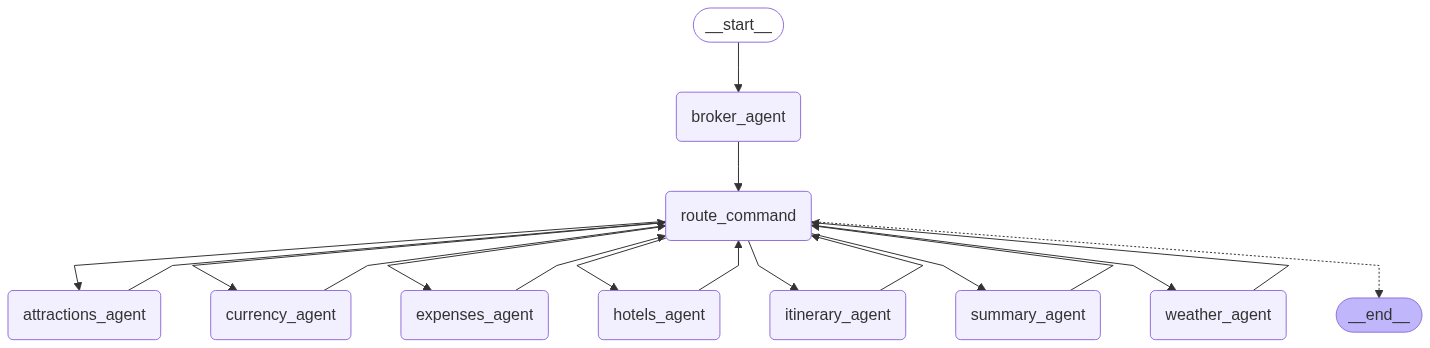

In [13]:
planner = TravelPlannerGraph()

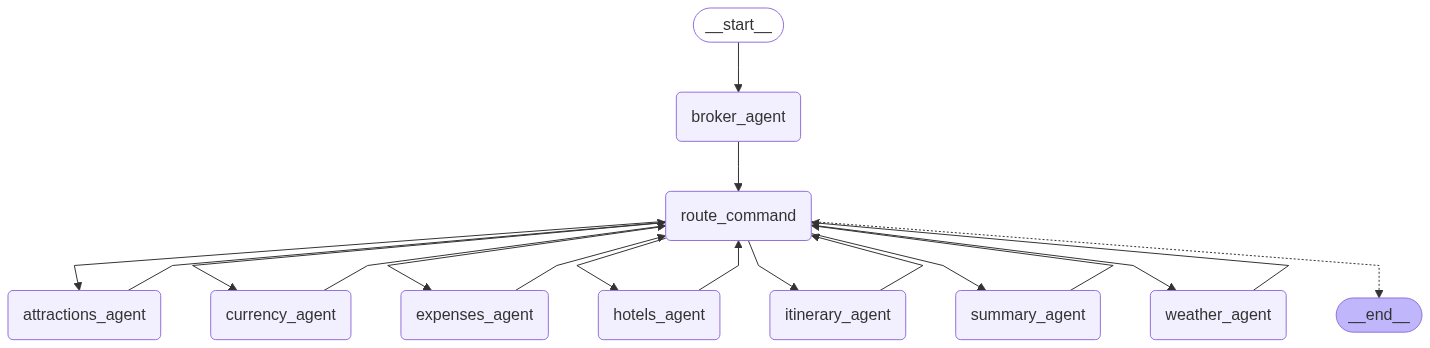

{'error': 'Graph execution failed: Expected dict, got weather_agent\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE'}
{'error': 'Graph execution failed: Expected dict, got summary_agent\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE'}


In [15]:
# create a new instance of the TravelPlannerGraph

planner = TravelPlannerGraph()
session_id = str(uuid.uuid4())

# Create a new travel plan
initial_command = Command(
    sender="user",
    recipient="broker_agent",
    command_type="plan_trip",
    payload={
        "city": "Paris",
        "start_date": "2025-07-01",
        "days": 5,
        "budget_range": (10, 300),
        "user_currency": "EUR"
    }
)
result = planner.execute_command(initial_command)
print(result)

summary_command = Command(
    sender="user",
    recipient="broker_agent",
    command_type="retrieve_plan"
)

summary_result = planner.execute_command(summary_command)
print(summary_result)